In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import editdistance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
import flexs
from flexs import baselines
import flexs.utils.sequence_utils as s_utils

## Figure 1A

First, create the landscape and train various models on a 100 sequence dataset

In [3]:
problem = flexs.landscapes.rna.registry()['L14_RNA1']
wt = problem['starts'][2]
landscape = flexs.landscapes.RNABinding(**problem['params'])

train_x = np.array(list(s_utils.generate_random_mutant(wt, 0.2*(i%5), alphabet=s_utils.RNAA)
                  for i in range(1000)))
train_y = landscape.get_fitness(train_x)

cnn_ensemble = flexs.Ensemble([
    baselines.models.CNN(len(wt), alphabet=s_utils.RNAA, num_filters=32, hidden_size=100, loss='MSE')
    for i in range(3)
])

models = {
    'alpha=1': baselines.models.NoisyAbstractModel(landscape, signal_strength=1),
    'alpha=0.9': baselines.models.NoisyAbstractModel(landscape, signal_strength=0.9),
    'alpha=0.75': baselines.models.NoisyAbstractModel(landscape, signal_strength=0.75),
    'alpha=0': baselines.models.NoisyAbstractModel(landscape, signal_strength=0),
    'CNN Ensemble': cnn_ensemble
}

for model in models.values():
    model.train(train_x, train_y)

Generate the validation set and compute correlation with true score by distance

In [4]:
import scipy.stats

val_x = np.array(list(s_utils.generate_random_mutant(wt, 0.2*(i%5), alphabet=s_utils.RNAA)
                  for i in range(1000)))
val_y = landscape.get_fitness(val_x)

def get_corr_per_distance(seqs, labels, preds):    
    corrs = []
    edit_distances = np.array([editdistance.eval(seq, wt) for seq in seqs])
    
    for dist in range(1, 11):
        seqs_at_dist = edit_distances == dist
        
        if seqs_at_dist.sum() > 50:
            corrs.append(
                scipy.stats.pearsonr(labels[seqs_at_dist], preds[seqs_at_dist])[0]**2
            )
        else:
            corrs.append(np.nan)
            
    return corrs

corrs = {
    name: get_corr_per_distance(val_x, val_y, model.get_fitness(val_x))
    for name, model in models.items()
}

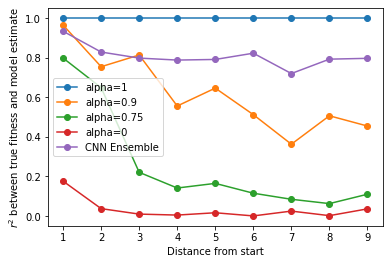

In [5]:
for name, corr in corrs.items():
    plt.plot(range(1, 11), corr, 'o-', label=name)
plt.ylabel("$r^2$ between true fitness and model estimate")
plt.xlabel("Distance from start")
plt.legend()
plt.show()

## Figure 2B

We run Adalead, CbAS, DbAS over 

In [11]:
problem = flexs.landscapes.rna.registry()['L14_RNA1+2']
wt = problem['starts'][2]
landscape = flexs.landscapes.RNABinding(**problem['params'])

In [17]:
for i in range(5):
    print(f'\nBeginning run {i}')
    adalead = baselines.explorers.Adalead(
        flexs.LandscapeAsModel(landscape),
        rounds=10,
        starting_sequence=wt,
        sequences_batch_size=100,
        model_queries_per_batch=1000,
        alphabet=s_utils.RNAA,
        log_file=f'plots/2b/adalead/{i}.csv'
    )
    adalead.run(landscape)


Beginning run 0


IsADirectoryError: [Errno 21] Is a directory: 'plots/2b/adalead/{i}.csv'

In [13]:
vae = baselines.explorers.VAE(len(wt), alphabet=s_utils.RNAA, epochs=10, verbose=False)
cbas_explorer = baselines.explorers.CbAS(
    flexs.LandscapeAsModel(landscape),
    vae,

    rounds=10,
    starting_sequence=wt,
    sequences_batch_size=100,
    model_queries_per_batch=1000,
    alphabet=s_utils.RNAA,
)
cbas_sequences, metadata = cbas_explorer.run(landscape)

round: 0, top: 0.27879076194752395


/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


round: 1, top: 0.63048526461411
round: 2, top: 0.63048526461411
round: 3, top: 0.7034926608034604
round: 4, top: 0.7034926608034604
round: 5, top: 0.7406958423906222
round: 6, top: 0.7406958423906222
round: 7, top: 0.7406958423906222
round: 8, top: 0.7406958423906222


KeyboardInterrupt: 

In [ ]:
def cumulative_max_per_round(sequences):
    num_rounds = sequences['round'].max() + 1
    max_per_round = [sequences['true_score'][sequences['round'] == r].max()
                     for r in range(num_rounds)]
    return np.maximum.accumulate(max_per_round)

plt.plot(range(11), cumulative_max_per_round(adalead_sequences), 'o-', label="adalead")
plt.show()